In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.4
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0153

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - loss: 0.0101
Average validation loss: 0.7214163541793823
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - loss: 0.0101 - val_loss: 0.7214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 496ms/step - loss: 0.0066 - val_loss: 0.7214
Average validation loss: 0.6259374022483826
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - loss: 0.0066 - val_loss: 0.6737
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - loss: 0.0047 - val_loss: 0.6737
Average validation loss: 0.5502653121948242
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 509ms/step - loss: 0.0047 - val_loss: 0.6325
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 810ms/step - loss: 5.0154e-07
Average validation loss: 0.05116990581154823
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 826ms/step - loss: 5.0154e-07 - val_loss: 0.0512
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - loss: 4.8104e-07 - val_loss: 0.0512
Average validation loss: 0.07122438587248325
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 808ms/step - loss: 4.8104e-07 - val_loss: 0.0612
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - loss: 4.6976e-07 - val_loss: 0.0612
Average validation loss: 0.10273102298378944
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 844ms/step - loss: 4.6976e-07 - val_loss: 0.0750
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 843ms/step - loss: 4.6064e-07 - val_loss: 0.0750
Average validation loss: 0.06411257199943066
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 852ms/step - loss: 4.6064e-07 - val_loss: 0.0723
Epoch 5/10
8/8 ━━━━━━━━━━━━

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 820ms/step - loss: 2.0578e-07
Average validation loss: 0.04853787956138452
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 833ms/step - loss: 2.0578e-07 - val_loss: 0.0485
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 795ms/step - loss: 1.9588e-07 - val_loss: 0.0485
Average validation loss: 0.05442211094001929
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 803ms/step - loss: 1.9588e-07 - val_loss: 0.0515
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 879ms/step - loss: 1.8657e-07 - val_loss: 0.0515
Average validation loss: 0.04426559122900168
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 889ms/step - loss: 1.8657e-07 - val_loss: 0.0491
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_15.pth'.
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 895ms/step - loss: 1.8260e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 850ms/step - loss: 1.2724e-07
Average validation loss: 0.03671474056318402
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 861ms/step - loss: 1.2724e-07 - val_loss: 0.0367
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 843ms/step - loss: 1.0820e-07 - val_loss: 0.0367
Average validation loss: 0.03913882654160261
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 854ms/step - loss: 1.0820e-07 - val_loss: 0.0379
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 853ms/step - loss: 1.0747e-07 - val_loss: 0.0379
Average validation loss: 0.04975974326953292
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 863ms/step - loss: 1.0747e-07 - val_loss: 0.0419
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 902ms/step - loss: 1.0399e-07 - val_loss: 0.0419
Average validation loss: 0.036381527315825224
16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 911ms/step - loss: 1.0399e-07 - val_loss: 0.0405
Saved mo

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 823ms/step - loss: 1.0846e-07
Average validation loss: 0.02209344319999218
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 833ms/step - loss: 1.0846e-07 - val_loss: 0.0221
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 955ms/step - loss: 9.7873e-08 - val_loss: 0.0221
Average validation loss: 0.01909428397193551
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 966ms/step - loss: 9.7873e-08 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 843ms/step - loss: 8.7547e-08 - val_loss: 0.0206
Average validation loss: 0.01602807464078069
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 853ms/step - loss: 8.7547e-08 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 1.4346e-07
Average validation loss: 0.024627026558543246
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 799ms/step - loss: 1.4346e-07 - val_loss: 0.0246
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 824ms/step - loss: 1.2731e-07 - val_loss: 0.0246
Average validation loss: 0.015805627141768735
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 834ms/step - loss: 1.2731e-07 - val_loss: 0.0202
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 781ms/step - loss: 1.1146e-07 - val_loss: 0.0202
Average validation loss: 0.016463417327031493
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 791ms/step - loss: 1.1146e-07 - val_loss: 0.0190
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 78s 816ms/step - loss: 9.81

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 776ms/step - loss: 1.5361e-07
Average validation loss: 0.0562774317804724
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 787ms/step - loss: 1.5361e-07 - val_loss: 0.0563
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 788ms/step - loss: 1.4059e-07 - val_loss: 0.0563
Average validation loss: 0.03883716412819922
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 798ms/step - loss: 1.4059e-07 - val_loss: 0.0476
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 790ms/step - loss: 1.2260e-07 - val_loss: 0.0476
Average validation loss: 0.050033714855089784
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 801ms/step - loss: 1.2260e-07 - val_loss: 0.0484
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 770ms/step - loss: 1.0964

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 775ms/step - loss: 1.0728e-07
Average validation loss: 0.025737981001536053
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 788ms/step - loss: 1.0728e-07 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 795ms/step - loss: 1.0860e-07 - val_loss: 0.0257
Average validation loss: 0.022663875405366223
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 806ms/step - loss: 1.0860e-07 - val_loss: 0.0242
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 781ms/step - loss: 1.0115e-07 - val_loss: 0.0242
Average validation loss: 0.02320220573650052
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 793ms/step - loss: 1.0115e-07 - val_loss: 0.0239
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 152s 783ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 42s 748ms/step - loss: 8.0385e-08
Average validation loss: 0.022683459766475216
56/56 ━━━━━━━━━━━━━━━━━━━━ 43s 759ms/step - loss: 8.0385e-08 - val_loss: 0.0227
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 768ms/step - loss: 7.8290e-08 - val_loss: 0.0227
Average validation loss: 0.025021409017166922
56/56 ━━━━━━━━━━━━━━━━━━━━ 86s 779ms/step - loss: 7.8290e-08 - val_loss: 0.0239
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 773ms/step - loss: 7.2760e-08 - val_loss: 0.0239
Average validation loss: 0.02190318550648434
56/56 ━━━━━━━━━━━━━━━━━━━━ 130s 785ms/step - loss: 7.2760e-08 - val_loss: 0.0232
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 175s 801ms/step - loss: 7.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - loss: 1.1037e-07
Average validation loss: 0.01623092670342885
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 793ms/step - loss: 1.1037e-07 - val_loss: 0.0162
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 790ms/step - loss: 9.6223e-08 - val_loss: 0.0162
Average validation loss: 0.015687419683672488
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 801ms/step - loss: 9.6223e-08 - val_loss: 0.0160
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 776ms/step - loss: 7.9811e-08 - val_loss: 0.0160
Average validation loss: 0.017811113561037928
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 788ms/step - loss: 7.9811e-08 - val_loss: 0.0166
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 203s 783ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 4.8678e-08
Average validation loss: 0.028029334886620443
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - loss: 4.8678e-08 - val_loss: 0.0280
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 778ms/step - loss: 5.2356e-08 - val_loss: 0.0280
Average validation loss: 0.028554079226321645
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 789ms/step - loss: 5.2356e-08 - val_loss: 0.0283
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 788ms/step - loss: 4.8527e-08 - val_loss: 0.0283
Average validation loss: 0.026290294248610735
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 799ms/step - loss: 4.8527e-08 - val_loss: 0.0276
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 799ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 808ms/step - loss: 4.9972e-08
Average validation loss: 0.016891808714717627
80/80 ━━━━━━━━━━━━━━━━━━━━ 65s 819ms/step - loss: 4.9972e-08 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 789ms/step - loss: 4.5161e-08 - val_loss: 0.0169
Average validation loss: 0.021310177631676197
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 800ms/step - loss: 4.5161e-08 - val_loss: 0.0191
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 193s 795ms/step - loss: 3.9880e-08 - val_loss: 0.0191
Average validation loss: 0.02404048233292997
80/80 ━━━━━━━━━━━━━━━━━━━━ 194s 806ms/step - loss: 3.9880e-08 - val_loss: 0.0207
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 263s 859ms/step - loss: 3.6391e-08 - val_loss: 0.0207
Average validation loss: 0.025186938885599374
80/80 ━━━━━━━━━━━━━━━━━━━━ 264s 870ms/step - loss: 3.6391e-08 - val_loss: 0.0219

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 897ms/step - loss: 3.1015e-07
Average validation loss: 0.03098538548996051
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 909ms/step - loss: 3.1015e-07 - val_loss: 0.0310
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 162s 776ms/step - loss: 2.4366e-07 - val_loss: 0.0310
Average validation loss: 0.02255010463219757
96/96 ━━━━━━━━━━━━━━━━━━━━ 163s 786ms/step - loss: 2.4366e-07 - val_loss: 0.0268
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 238s 785ms/step - loss: 1.9253e-07 - val_loss: 0.0268
Average validation loss: 0.02777639355432863
96/96 ━━━━━━━━━━━━━━━━━━━━ 239s 795ms/step - loss: 1.9253e-07 - val_loss: 0.0271
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 314s 784ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 781ms/step - loss: 3.9613e-07
Average validation loss: 0.018284297129139305
120/120 ━━━━━━━━━━━━━━━━━━━━ 95s 792ms/step - loss: 3.9613e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 189s 786ms/step - loss: 3.8171e-07 - val_loss: 0.0183
Average validation loss: 0.038365717977285385
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 797ms/step - loss: 3.8171e-07 - val_loss: 0.0283
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 285s 789ms/step - loss: 3.6557e-07 - val_loss: 0.0283
Average validation loss: 0.020073042918617525
120/120 ━━━━━━━━━━━━━━━━━━━━ 287s 800ms/step - loss: 3.6557e-07 - val_loss: 0.0256
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 382s 791ms/step - loss: 3.6302e-07 - val_loss: 0.0256
Average validation loss: 0.020143441560988625
120/120 ━━━━━━━━━━━━━━━━━━━━ 383s 802ms/step - loss: 3.6302e-07 -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 120s 836ms/step - loss: 1.1115e-07
Average validation loss: 0.020079519916584507
144/144 ━━━━━━━━━━━━━━━━━━━━ 122s 847ms/step - loss: 1.1115e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 236s 790ms/step - loss: 1.0307e-07 - val_loss: 0.0201
Average validation loss: 0.018059703810851917
144/144 ━━━━━━━━━━━━━━━━━━━━ 237s 801ms/step - loss: 1.0307e-07 - val_loss: 0.0191
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 353s 800ms/step - loss: 9.1208e-08 - val_loss: 0.0191
Average validation loss: 0.018690255625794332
144/144 ━━━━━━━━━━━━━━━━━━━━ 354s 811ms/step - loss: 9.1208e-08 - val_loss: 0.0189
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 468s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 783ms/step - loss: 9.0595e-08
Average validation loss: 0.01711551334192336
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 794ms/step - loss: 9.0595e-08 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 788ms/step - loss: 7.7162e-08 - val_loss: 0.0171
Average validation loss: 0.015718845785886514
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 799ms/step - loss: 7.7162e-08 - val_loss: 0.0164
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 380s 781ms/step - loss: 6.9098e-08 - val_loss: 0.0164
Average validation loss: 0.016553963100886904
160/160 ━━━━━━━━━━━━━━━━━━━━ 381s 791ms/step - loss: 6.9098e-08 - val_loss: 0.0165
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 507s 7

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 790ms/step - loss: 6.6068e-08
Average validation loss: 0.018623450268351008
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 801ms/step - loss: 6.6068e-08 - val_loss: 0.0186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 318s 786ms/step - loss: 6.7945e-08 - val_loss: 0.0186
Average validation loss: 0.016347626935457812
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 797ms/step - loss: 6.7945e-08 - val_loss: 0.0175
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 478s 793ms/step - loss: 1.9221e-07 - val_loss: 0.0175
Average validation loss: 0.020390401900513097
200/200 ━━━━━━━━━━━━━━━━━━━━ 480s 804ms/step - loss: 1.9221e-07 - val_loss: 0.0185
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 639s 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 809ms/step - loss: 6.4048e-08
Average validation loss: 0.01824115731845571
240/240 ━━━━━━━━━━━━━━━━━━━━ 197s 820ms/step - loss: 6.4048e-08 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_40\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 401s 849ms/step - loss: 5.6209e-08 - val_loss: 0.0182
Average validation loss: 0.020523485171603777
240/240 ━━━━━━━━━━━━━━━━━━━━ 404s 861ms/step - loss: 5.6209e-08 - val_loss: 0.0194
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 598s 808ms/step - loss: 4.9673e-08 - val_loss: 0.0194
Average validation loss: 0.02352663261650984
240/240 ━━━━━━━━━━━━━━━━━━━━ 600s 819ms/step - loss: 4.9673e-08 - val_loss: 0.0208
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 797s 818ms/step - loss: 4.6629e-08 - val_loss: 0.0208
Average validation loss: 0.02085109657182329
240/240 ━━━━━━━━━━━━━━━━━━━━ 799s 829ms/step - loss: 4.6629e-08 - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.13801391128450632, 0.042581015648320314, 0.034522441383451216, 0.02769394890172407, 0.01765751890558749, 0.015092705033409102, 0.037281731055118145, 0.026516937859511622, 0.02384064212175352, 0.02211334671708755, 0.02416282660586553, 0.024432952116243543, 0.026666481169328713, 0.03877968325139955, 0.02291742322628125, 0.020938068296616617, 0.02101725201612353, 0.02051247667012224]
std_val_losses =  [0.16684704017189805, 0.020661391601972588, 0.009786690429266843, 0.009051426622433939, 0.0049158430634837335, 0.004337643556742374, 0.009812981829654161, 0.005061511912962803, 0.003064822324334229, 0.0034469653681431316, 0.005882963694781422, 0.004082538424261721, 0.007748525777107996, 0.10940523197847977, 0.004739955002197779, 0.0037220574902862005, 0.0025466426956362253, 0.0024471410984858227]


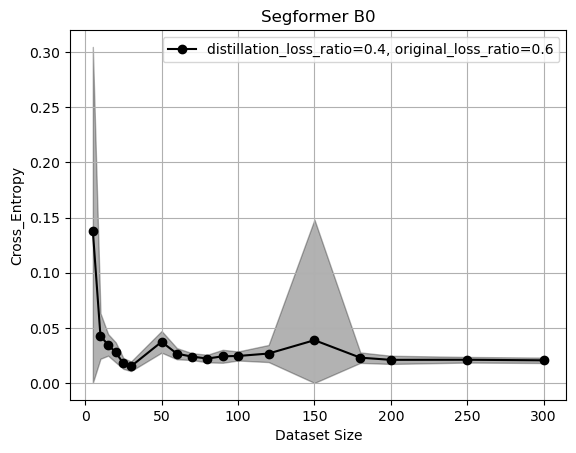

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()